The absorbtion module is used to calculate TBabs-like photoelectric absorbtion and gamma-gamma absorbtion on the background field of the star photons. Both photoelectric absobtion and gg-absorbtion coefficients should not be taken too seriously: if your task is to investigate the importance of absorbtion on something or the dependence of absorbtion coefficients themselves on parameters, I would use `ibsen.absorbtion` only as the first estimate. Thoug both coefficients should not differ from the properly calculated ones more than a few percent.

First, let's look at the TBabs absorbtion. I...um...borrowed the dependence $\sigma(E)$ from https://arxiv.org/pdf/astro-ph/0008425, which is tabulated and shipped together with `ibsen`, and the coefficient is calculated as
\begin{equation}
e^{-\sigma (E) N_\mathrm{H}}.
\end{equation}


Text(0, 0.5, '$e^{-\\tau}$')

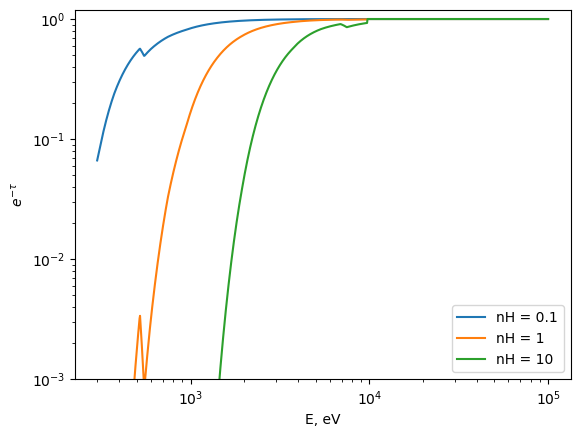

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ibsen.absorbtion.absorbtion as absb

E = np.geomspace(3e2, 1e5, 1000)
for Nh in (0.1, 1, 10):
    photoel_coef = absb.abs_photoel(E=E, # in eV
                                   Nh = Nh # in 1e22 [g cm^-2], as in XSpec
                                   )
    plt.plot(E, photoel_coef, label=f"nH = {Nh}")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1.2)
plt.xlabel(r'E, eV')
plt.ylabel(r'$e^{-\tau}$')




For the $\gamma-\gamma$ absorbtion there is a function written by me that calculates $\tau_{\gamma \gamma}(E, x, y, T_\mathrm{opt}, ...)$, where $(x, y)$ are coordinates in the orbital plane. It follows Dubus 2006 (https://arxiv.org/pdf/astro-ph/0509633), and Sushch & van Soelen 2017, 2023 (https://arxiv.org/pdf/1703.00680, https://arxiv.org/pdf/2310.01102) in a "point-source approximation". Essentially, it is the assumption that the integrand (see further) is a constant for any direction crossing the star, and zero otherwise. With this assumption,

\begin{equation}
\tau_{\gamma \gamma}(e) = \pi \int_0^\infty dl (1-\mu_\mathrm{int}(l)) \left(\frac{R_\mathrm{opt}}{d(l)}\right)^2 
\int_{e_\mathrm{min}}^\infty de_* \sigma_{\gamma \gamma}(e, e_*, l) n_*(e_*, l),
\end{equation}

where $l$ is a distance traveled by a VHE photon of energy $e$ from the emission point, and  see Dubus (2006), Sushch, van Soelen (2023) for the rest.

While you _can_ use this function: `ibsen.absorbtion.absorbtion.tau_gg_iso_2d`, it was not vectorized or parallziedm and also even one calculation at one energy takes a considerable time. That is why there is also a kind of wrapper around this function: `tabulate_absgg` which parallizes calculations over $E$-axis and then can save the result as a table. 

For example, let's tabulate such table (the expression is commented because it takes about a minute, and it creates a file):

In [2]:
from ibsen.orbit import Orbit
from ibsen.absorbtion.absorbtion import tabulate_absgg
import time
DAY = 86400
start = time.time()
orb = Orbit(T=1000*DAY, e=0.4, M=30*2e33, nu_los=90.0/180*np.pi,incl_los=30.0/180*np.pi)
tabulate_absgg(orb=orb, nrho=8, nphi=12, ne=24, # number of nods over r, phi, E. Better increase by about 2-3 times.
               Topt=3e4, Ropt=10*7e10,
               to_return=False, # whether to return res, xx, yy, es (see docs)
               fast=True, # Whether to calculate faster but (slightly) incorrectly.
               filename='gg_test', # filename to save the result to. You'll have to pass it as an argument to the interpolator
              )
print(time.time() - start)

29.371777534484863


The fastest way to get the $\gamma-\gamma$ absorbtion coefficient is to read this table and interpolate the result for the desirable spatial coordinates and energies. For this purpose, there is a function which is used in all spectrum-related calculations. Let's compare performance of this interpolator function VS "honest" calculation:

Interpolation,  0.006672382354736328
Calculation,  1.2329127788543701
Interpolation,  0.005380153656005859
Calculation,  1.4016869068145752
Interpolation,  0.004992961883544922
Calculation,  1.4158153533935547
Interpolation,  0.005475521087646484
Calculation,  1.389995813369751
Interpolation,  0.005049705505371094
Calculation,  1.4001452922821045


/tmp/ipykernel_16943/583825264.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


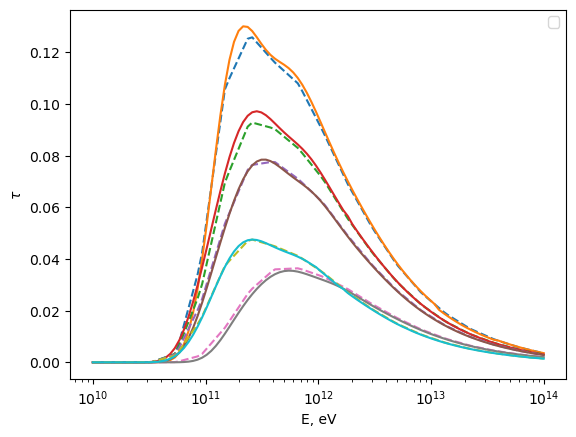

In [3]:
"""
Test over energies
"""
from ibsen.absorbtion.absorbtion import gg_tab

plt.close('all')
eplot = np.geomspace(1e10, 1e14, 100)

for tplot in (-50, -10, 5, 60, 600):
    tplot = tplot * DAY
    x, y = orb.x(tplot), orb.y(tplot)
    st = time.time()
    res_= gg_tab(eplot, x, y, orb, what_return='tau', filename='gg_test')
    print('Interpolation, ', time.time() - st)
    plt.plot(eplot, res_, ls='--')
    from ibsen.absorbtion.absorbtion import tau_gg_iso_2d
    st = time.time()

    res_an = np.array([tau_gg_iso_2d(eg=e_/5.11e5, x=x, y=y, R_star=10*7e10, T_star=3e4,
                nu_los=orb.nu_los, incl_los=orb.incl_los, fast=True)
                      for e_ in eplot])
    plt.plot(eplot, res_an)
    print('Calculation, ', time.time() - st)
plt.legend()

plt.xlabel('E, eV')
plt.ylabel(r'$\tau$')


plt.xscale('log')
plt.show()

Interpolation,  0.01676797866821289
Calculation,  1.0126986503601074
Interpolation,  0.011043071746826172
Calculation,  1.2046892642974854
Interpolation,  0.01079559326171875
Calculation,  1.789731740951538


/tmp/ipykernel_16943/2424989000.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


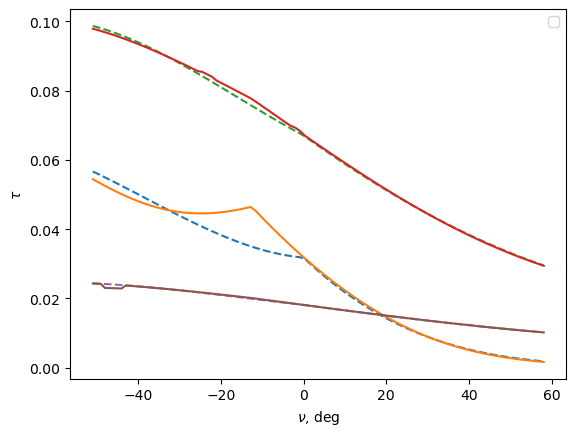

In [4]:
"""
Test over coordinates: compare tau(1 TeV) over the pulsar orbit tab VS analyt
"""
plt.close('all')  

tplot = np.linspace(-60, 70, 100) * DAY
x, y, nu = orb.x(tplot), orb.y(tplot), orb.true_an(tplot)

for E in (1e11, 1e12,  1e13, ):
    st = time.time()
    res_ = gg_tab(E, x, y, orb, what_return='tau', filename='gg_test')
    print('Interpolation, ', time.time() - st)
    plt.plot(nu/np.pi*180, res_, ls='--')    
    st = time.time()

    res_an = np.array([
        tau_gg_iso_2d(eg=E/5.11e5, x=xi, y=yi, R_star=10*7e10, T_star=3e4,
                nu_los=orb.nu_los, incl_los=orb.incl_los, fast=True) 
                       for xi, yi in zip(x, y) ])
    plt.plot(nu/np.pi*180, res_an)
    print('Calculation, ', time.time() - st)
        
plt.legend()

plt.xlabel(r'$\nu$, deg')
plt.ylabel(r'$\tau$')


plt.show()

Another method to tabulate the absorbtion is to use the script `tab_gg_opac` in `IBSEn`. You can run it as

```bash
> cd IBSEn
> python3 tab_gg_opac.py --T 1000.0 --e 0.4 --M 30.0 --nu_los 90.0 --incl_los 30.0 --Topt 3e4 --Ropt 10 --filename 'gg_test' --nrho 15 --nphi 16 --ne 24 --fast True
```